# Usage demo for the WDC package


In [1]:
from wdc import DatabaseConnection, Datacube

import plotly.express as px
from pandas import read_csv
import io

import plotly.io as pio
pio.renderers.default = "svg"

## Create `Connection` and `Datacube` objects


In [2]:
conn = DatabaseConnection(endpoint_url="https://ows.rasdaman.org/rasdaman/ows")
dataCube = Datacube(conn, "AvgLandTemp")

### selecting a single value


In [3]:
# Create a query builder instance
singleValueQuery = dataCube.getQueryBuilder(debug=True)

# write query by chaining operations
singleValueQuery.subset(lat=53.08, long=8.80, startDate="2014-07")
queryRes = dataCube.execute_query(singleValueQuery)

display(queryRes)

for $c in (AvgLandTemp) return $c[Lat(53.08),Long(8.8),ansi("2014-07")]


'25.984251'

### 3D -> 1D subset


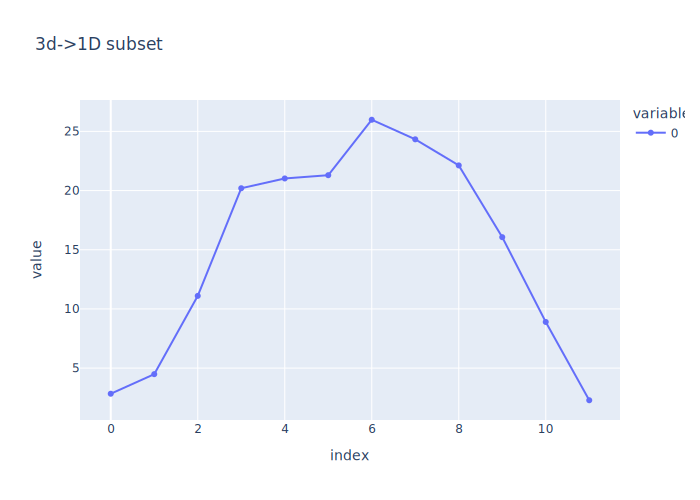

In [4]:
# Create a query builder instance
graphQuery = dataCube.getQueryBuilder()
graphQuery.subset(lat=53.08, long=8.80, startDate="2014-01", endDate="2014-12")

queryRes = dataCube.execute_query(graphQuery, "CSV")

fig = px.line(queryRes, title="3d->1D subset", markers=True)
display(fig)

### 3D -> 2D subset


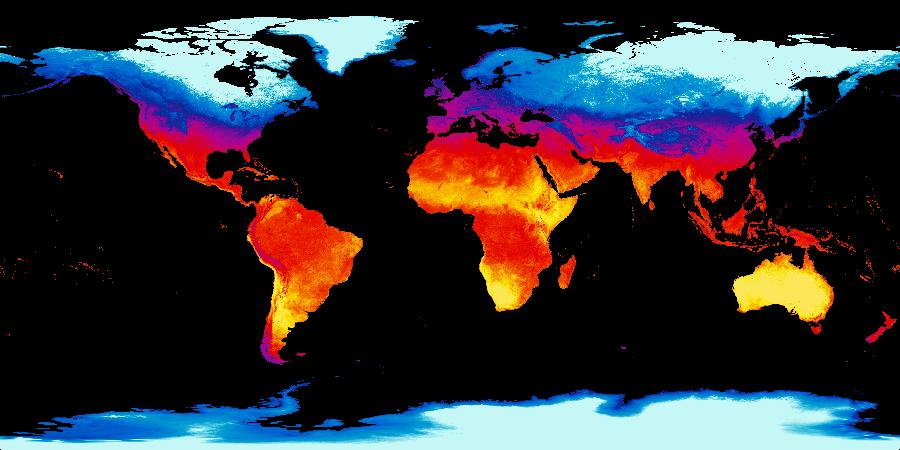

In [5]:
avgTempDataCube = Datacube(conn, 'AvgTemperatureColorScaled')

imgQuery = avgTempDataCube.getQueryBuilder()
imgQuery.subset(startDate="2014-01")

image = avgTempDataCube.execute_query(imgQuery, "JPEG")

display(image)

### Celsius to Kelvin


for $c in (AvgLandTemp) return encode($c[Lat(53.08),Long(8.8),ansi("2014-01":"2014-12")] + 273.15, "text/csv")


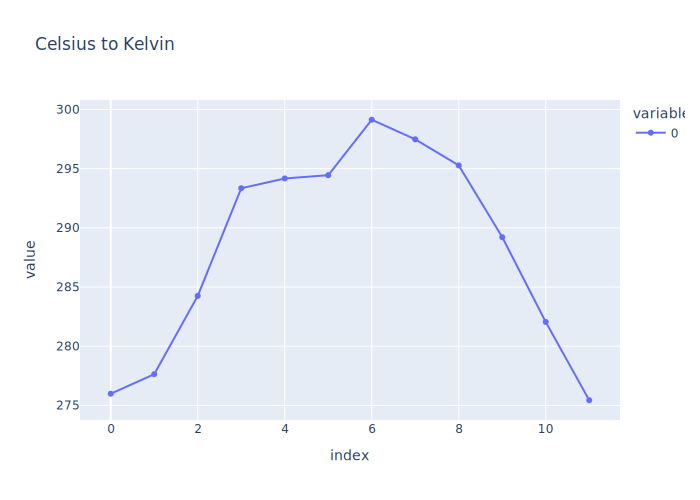

In [6]:
graphQuery = dataCube.getQueryBuilder(debug=True)
graphQuery.subset(lat=53.08, long=8.80, startDate="2014-01",
                  endDate="2014-12").arthimetic("ADD", 273.15)
queryRes = avgTempDataCube.execute_query(graphQuery, 'CSV')

fig = px.line(queryRes, title="Celsius to Kelvin", markers=True)
display(fig)

### Min, Max, Avg queries

Also shows how to use the pop operation


In [7]:
singleValueQuery = dataCube.getQueryBuilder()
slice = singleValueQuery.subset(
    lat=53.08, long=8.80, startDate="2014-01", endDate="2014-12")

minQueryRes = dataCube.execute_query(slice.aggregationFuncs("MIN"))

slice.pop()

maxQueryRes = dataCube.execute_query(slice.aggregationFuncs("MAX"))
slice.pop()

avgQueryRes = dataCube.execute_query(slice.aggregationFuncs("AVG"))
slice.pop()

sumQueryRes = dataCube.execute_query(slice.aggregationFuncs("SUM"))
slice.pop()

countQueryRes = dataCube.execute_query(
    slice.compareFuncs("LT", 30).aggregationFuncs("COUNT"))


min = minQueryRes
max = maxQueryRes
avg = avgQueryRes
count = countQueryRes
_sum = sumQueryRes

print("Min:\t", min, "\nMax:\t", max, "\nAvg:\t",
      avg, "\nCount:\t", count, "\nSum:\t", _sum)

Min:	 2.2834647 
Max:	 25.984251 
Avg:	 15.052493472894033 
Count:	 12 
Sum:	 180.6299216747284


### When is temperature above 15 ?


In [8]:
singleValueQuery.reset()
queryRes = dataCube.execute_query(
    singleValueQuery.subset(
        lat=53.08, long=8.80, startDate="2014-01", endDate="2014-12"
    )
    .compareFuncs("GT", 15)
    .aggregationFuncs("COUNT"),
    raw=True,
)

queryRes

b'7'

### On-the-fly coloring (switch)


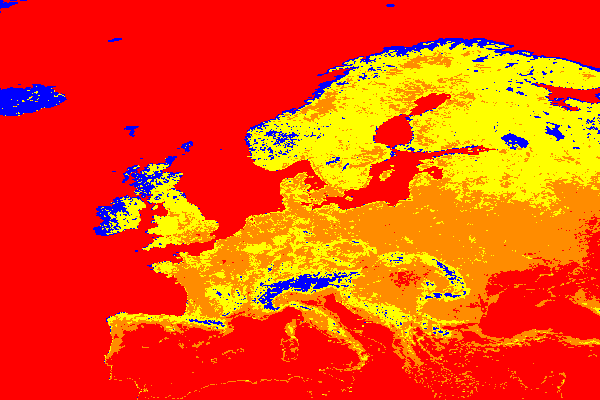

In [9]:
switchCaseQuery = dataCube.getQueryBuilder()

condition1 = dataCube.getQueryBuilder().compareFuncs("EQ", 99999)
condition2 = dataCube.getQueryBuilder().compareFuncs("LT", 18)
condition3 = dataCube.getQueryBuilder().compareFuncs("LT", 23)
condition4 = dataCube.getQueryBuilder().compareFuncs("LT", 30)

intermediateSlices = list( 
    zip(
        [condition1, condition2, condition3, condition4, None],
        [(255, 255, 255), (0, 0, 255), (255, 255, 0), (255, 140, 0), (255, 0, 0)],
    )
)

image = dataCube.execute_query(
    switchCaseQuery.conditionalReturn(intermediateSlices)
    .subset(startDate="2014-07", lat=(35, 75), long=(-20, 40)),
    encodingFormat="PNG"
)

display(image)

### Polygon Clipping


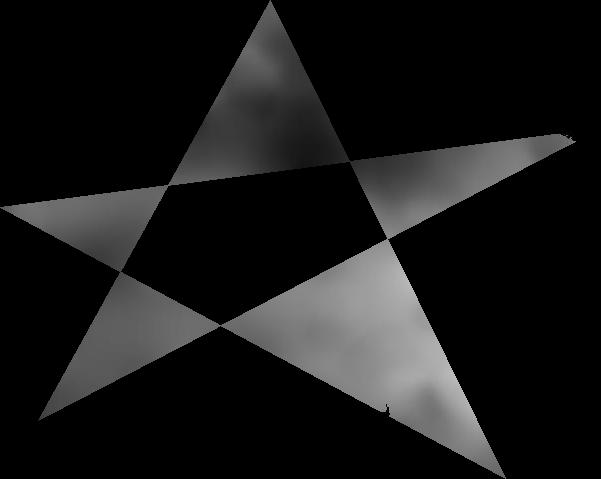

In [10]:
meanAirSummerTempCube = Datacube(conn, 'mean_summer_airtemp')
polygonQuery = meanAirSummerTempCube.getQueryBuilder()

polygon = [(-12.3829, 132.0117), (-33.4314, 120.4102), (-18.8127,
                                                        148.5352), (-22.7559, 118.4766), (-36.3151, 143.7891)]

polygonQuery.clip(
    clipType='Polygon', clippingValue=polygon)


image = meanAirSummerTempCube.execute_query(polygonQuery, encodingFormat='JPEG')
display(image)

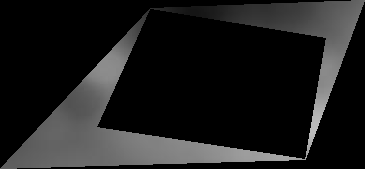

In [11]:
polygonQuery.reset()
poly1 = [(-20.4270, 131.6931), (-28.4204, 124.1895),
         (-27.9944, 139.4604), (-26.3919, 129.0015)]
poly2 = [(-20.4270, 131.6931), (-19.9527, 142.4268),
         (-27.9944, 139.4604), (-21.8819, 140.5151)]

multiPolygon = [poly1, poly2]

polygonQuery.clip(
    clipType='Multipolygon', clippingValue=multiPolygon)
image = meanAirSummerTempCube.execute_query(polygonQuery, encodingFormat="PNG")
display(image)

for $c in (mean_summer_airtemp) return encode(clip($c, LineString(-29.3822 120.2783,-19.5184 144.4043)), "text/csv")


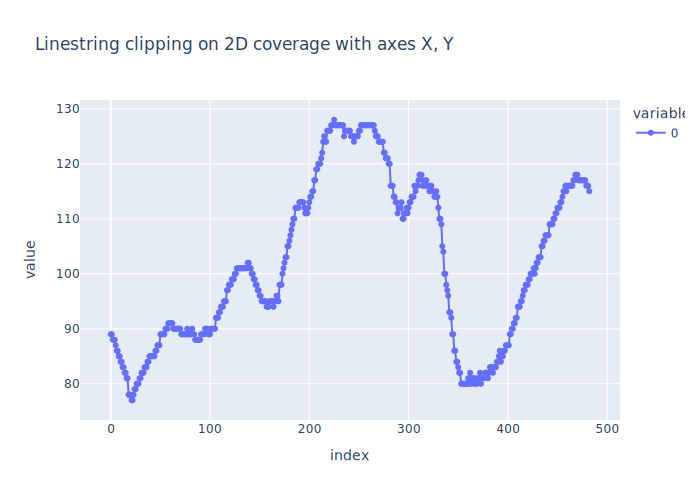

In [12]:
polygonQuery.reset()
polygonQuery.debug = True

lineString = [(-29.3822, 120.2783), (-19.5184, 144.4043)]

polygonQuery.clip(
    clipType='LineString', clippingValue=lineString)

clippedDF = meanAirSummerTempCube.execute_query(polygonQuery, "CSV")
fig = px.line(
    clippedDF, title="Linestring clipping on 2D coverage with axes X, Y", markers=True)
display(fig)

### Trignometric and Exponential Operations


In [13]:
graphQuery.reset()
graphQuery.subset(
    lat=53.08, long=8.80, startDate="2014-01", endDate="2014-12")

$c[Lat(53.08),Long(8.8),ansi("2014-01":"2014-12")]

for $c in (AvgLandTemp) return encode(cos($c[Lat(53.08),Long(8.8),ansi("2014-01":"2014-12")]), "text/csv")


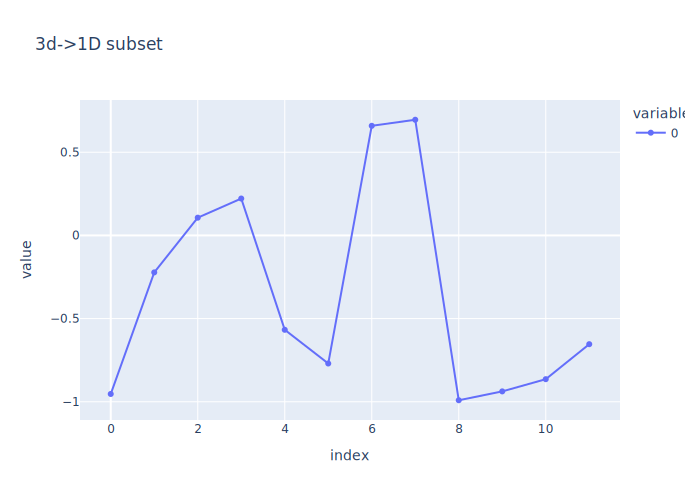

In [14]:
graphQuery.trigFuncs("COS")

csvDF = dataCube.execute_query(graphQuery, "CSV")
fig = px.line(csvDF, title="3d->1D subset", markers=True)
display(fig)

for $c in (AvgLandTemp) return encode(sqrt($c[Lat(53.08),Long(8.8),ansi("2014-01":"2014-12")]), "text/csv")


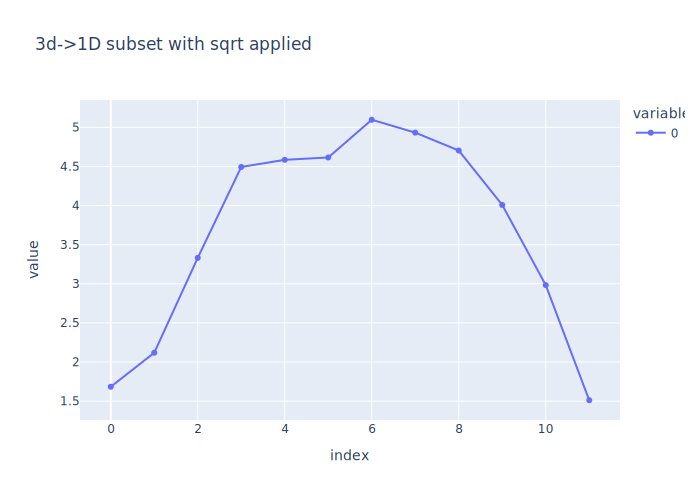

In [15]:
graphQuery.pop()
csvDF = dataCube.execute_query(graphQuery.expFuncs("SQRT"), "CSV")

fig = px.line(csvDF, title="3d->1D subset with sqrt applied", markers=True)
display(fig)

### Scalar Scaling


Unscaled


for $c in (mean_summer_airtemp) return encode($c, "image/jpeg")
(886, 711)


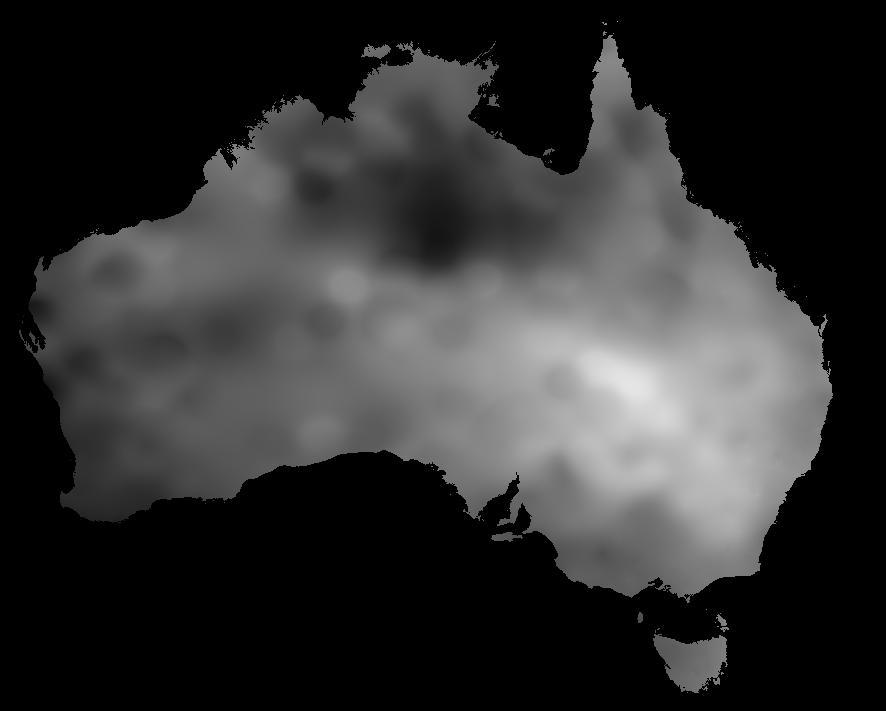

In [16]:
polygonQuery.reset()

image = meanAirSummerTempCube.execute_query(polygonQuery, "JPEG")

print(image.size)
image

Scaled


for $c in (mean_summer_airtemp) return encode(scale($c, 2), "image/jpeg")
(1771, 1421)


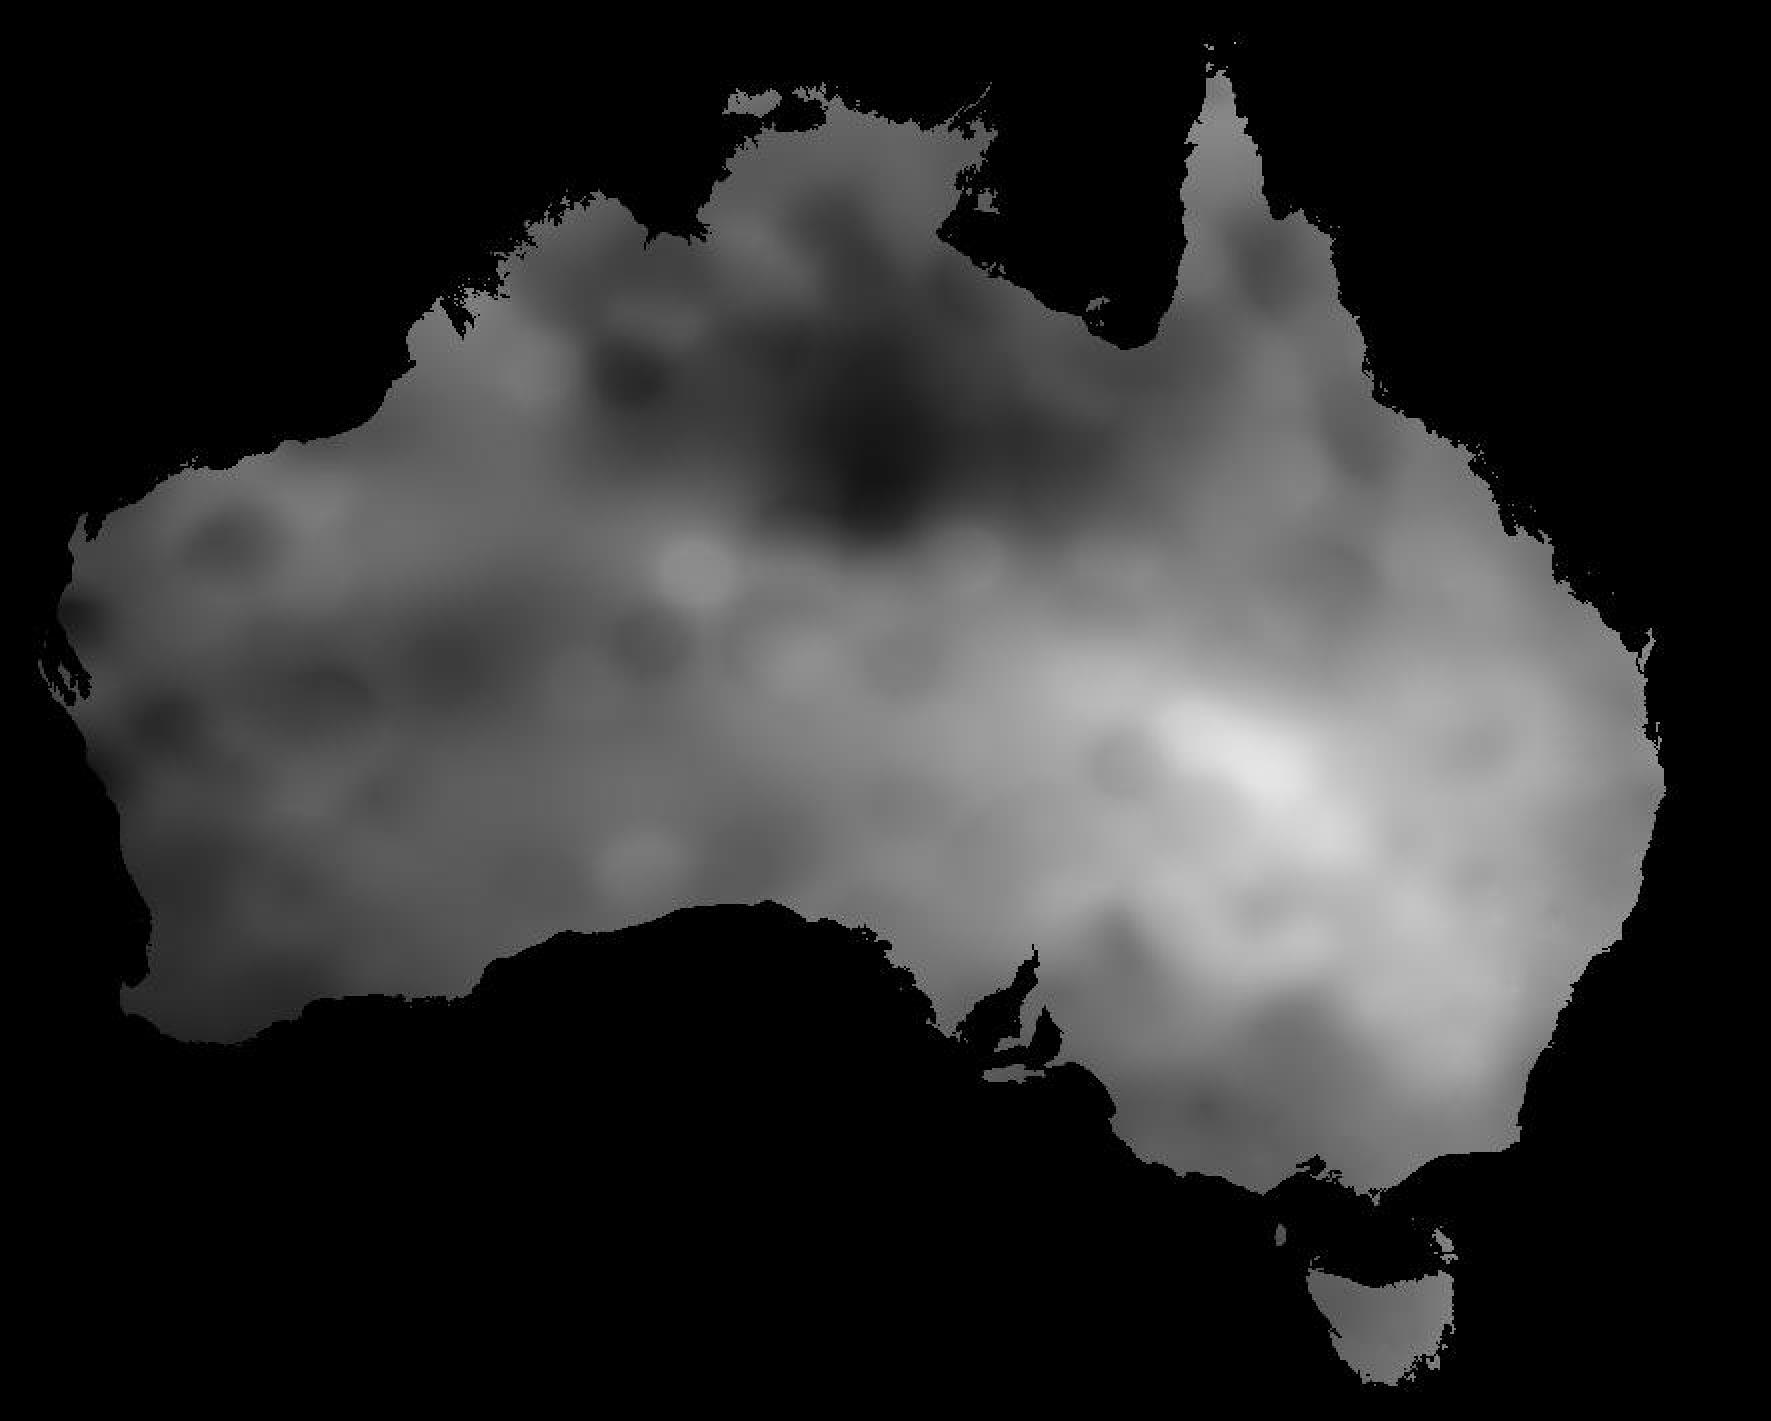

In [17]:
polygonQuery.reset()

image = meanAirSummerTempCube.execute_query(polygonQuery.scale(2), "JPEG")

print(image.size)
image

### Invalid Query


In [18]:
import lxml.etree as etree


invalidQuery = dataCube.execute_query(singleValueQuery.clip(
    clipType='Polygon', clippingValue=polygon).aggregationFuncs("COUNT"))

display(invalidQuery)

x = etree.parse(io.BytesIO(invalidQuery["errorDetails"]))
print(etree.tostring(x, pretty_print=True, encoding=str))

{'success': False,
 'result': None,
 'httpCode': 400,
 'httpError': '400 Client Error:  for url: https://ows.rasdaman.org/rasdaman/ows',
 'errorDetails': b'<?xml version="1.0" encoding="UTF-8" standalone="yes"?>\n<ows:ExceptionReport version="2.0.1"\n    xsi:schemaLocation="http://www.opengis.net/ows/2.0 http://schemas.opengis.net/ows/2.0/owsExceptionReport.xsd"\n    xmlns:ows="http://www.opengis.net/ows/2.0" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xmlns:xlink="http://www.w3.org/1999/xlink">\n    <ows:Exception exceptionCode="InvalidRequest" >\n        <ows:ExceptionText>Invalid input WKT for clipping operator. Reason: Number of dimensions in WKT \'2\' is different from coverage\'s \'1\'.</ows:ExceptionText>\n    </ows:Exception>\n</ows:ExceptionReport>\n'}

<ows:ExceptionReport xmlns:ows="http://www.opengis.net/ows/2.0" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xmlns:xlink="http://www.w3.org/1999/xlink" version="2.0.1" xsi:schemaLocation="http://www.opengis.net/ows/2.0 http://schemas.opengis.net/ows/2.0/owsExceptionReport.xsd">
    <ows:Exception exceptionCode="InvalidRequest">
        <ows:ExceptionText>Invalid input WKT for clipping operator. Reason: Number of dimensions in WKT '2' is different from coverage's '1'.</ows:ExceptionText>
    </ows:Exception>
</ows:ExceptionReport>

